In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math

In [2]:
path ='/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/'
raw_data = sio.loadmat(path + 'Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'Simulation_tensor_SiDisl_slc5_1000FPS_24-78_alternate3D.mat')
denoised_data = denoised_data['est_HOOI']

In [3]:
# Origianl way of unwrapping 4D data, leave real dimensions
denoised_data_2 = sio.loadmat(path + 'Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data_2 = denoised_data_2['est_HOOI']
denoised_data_2 = np.reshape(denoised_data_2,(114,114,128,128))

In [4]:
raw_data = np.reshape(raw_data,(114,114,128,128))
denoised_data = np.reshape(denoised_data,(128,128,114,114))
truth_data = np.reshape(truth_data,(114,114,128,128))

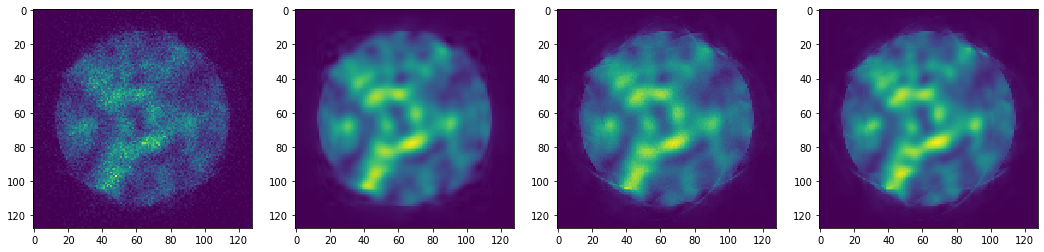

In [5]:
plt.figure(figsize=(18,6))
ix = 50
iy = 50
clim_max = np.amax(truth_data[ix,iy,:,:])
clim_min = np.amin(truth_data[ix,iy,:,:])

plt.subplot(141)
plt.imshow(raw_data[ix,iy,:,:])

plt.subplot(142)
plt.imshow(np.transpose(denoised_data[:,:,iy,ix]),clim=[clim_min,clim_max])

plt.subplot(143)
plt.imshow(denoised_data_2[ix,iy,:,:],clim=[clim_min,clim_max])

plt.subplot(144)
plt.imshow(truth_data[ix,iy,:,:],clim=[clim_min,clim_max])

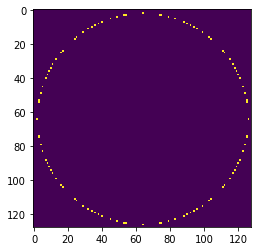

In [9]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61.7)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised_2 = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i,j]
            ADF_denoised_2 = ADF_denoised_2 + denoised_data_2[:,:,i,j]
            ADF_denoised = ADF_denoised + denoised_data[i,j,:,:]
            ADF_truth = ADF_truth + truth_data[:,:,i,j]

In [ ]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(141)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(142)
plt.imshow(np.transpose(ADF_denoised),clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(143)
plt.imshow(ADF_denoised_2,clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(144)
plt.imshow(ADF_truth,clim=[clim_low,clim_high])
plt.title('Truth Data')
# plt.axis('off')
plt.colorbar()

In [69]:
# calculate PSNR for each real space position, result in Decibel
psnr_map_1 = np.zeros((truth_data.shape[0],truth_data.shape[1]))
psnr_map_2 = np.zeros((truth_data.shape[0],truth_data.shape[1]))
for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:,:]
        denoise = np.transpose(denoised_data[:,:,icol,irow])
        psnr_map_1[irow,icol] = psnr(truth,denoise)
        denoise = denoised_data_2[irow,icol,:,:]
        psnr_map_2[irow,icol] = psnr(truth,denoise)

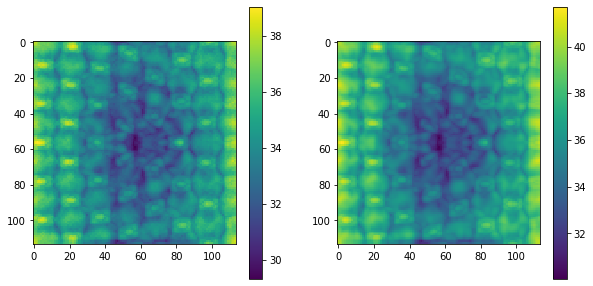

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(psnr_map_1)
plt.colorbar()
plt.subplot(122)
plt.imshow(psnr_map_2)
plt.colorbar()

## Overall plot

Text(0.5, 0, 'Components')

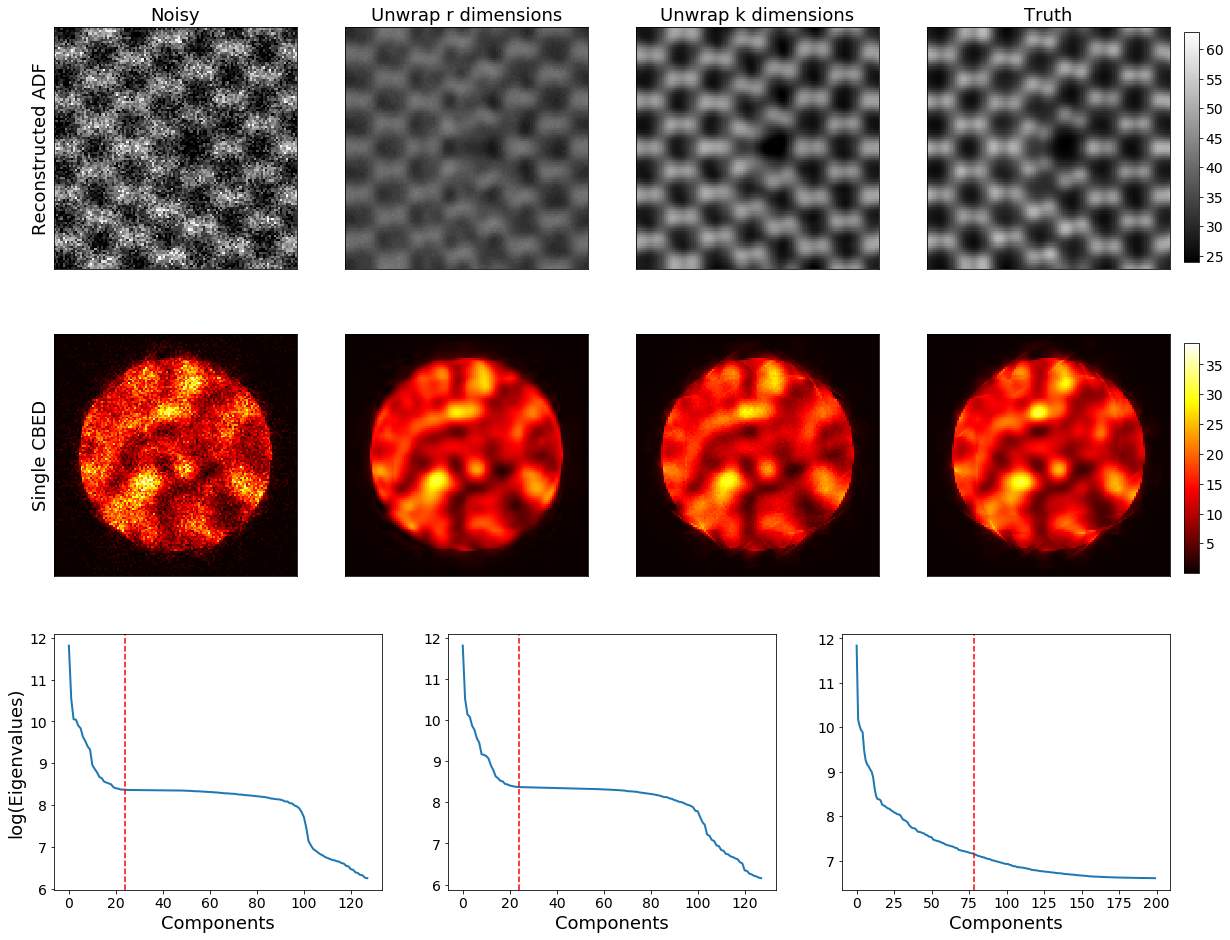

In [12]:
# overall plot
fig = plt.figure(figsize=(20,16))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)


fig.add_subplot(341)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Noisy',fontsize=18)
plt.ylabel('Reconstructed ADF', fontsize=18)

fig.add_subplot(342)
plt.imshow(np.transpose(ADF_denoised),clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Unwrap r dimensions',fontsize=18)

fig.add_subplot(343)
plt.imshow(ADF_denoised_2,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Unwrap k dimensions',fontsize=18)

ax = fig.add_subplot(344)
im = plt.imshow(ADF_truth,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Truth',fontsize=18)

cax = fig.add_axes([0.91,0.67,0.01,0.2])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

rx = 50
ry = 60
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

fig.add_subplot(3,4,5)
plt.imshow(raw_data[rx,ry,:,:],clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
plt.ylabel('Single CBED', fontsize=18)

fig.add_subplot(3,4,6)
plt.imshow(np.transpose(denoised_data[:,:,ry,rx]),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])

fig.add_subplot(3,4,7)
plt.imshow(denoised_data_2[rx,ry,:,:],clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(3,4,8)
im = plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# divider = make_axes_locatable(ax)

cax = fig.add_axes([0.91,0.4,0.01,0.2])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=14)

temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_1000FPS_eigenvalue_new3Dorder.mat')

fig.add_subplot(337)
e1 = temp['e1']
plt.plot(np.log(e1[::-1]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=24,color='r',ls='--')
plt.ylabel('log(Eigenvalues)',fontsize=18)
plt.xlabel('Components',fontsize=18)

fig.add_subplot(338)
e2 = temp['e2']
plt.plot(np.log(e2[::-1]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=24,color='r',ls='--')
# plt.ylabel('Eigenvalues',fontsize=14)
plt.xlabel('Components',fontsize=18)

fig.add_subplot(339)
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.log(e3[:200]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=78,color='r',ls='--')
# plt.ylabel('Eigenvalues',fontsize=14)
plt.xlabel('Components',fontsize=18)

# fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
# fig.savefig('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/SiDisl_tensor_result.tif')

In [7]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [8]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask